In [2]:
import cv2
import os
import numpy as np
import pandas as pd
from skimage.feature import graycomatrix, graycoprops
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

In [3]:
def extract_hsv(img):
    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    hist_h = cv2.calcHist([hsv_img], [0], None, [180], [0, 180]) 
    hist_s = cv2.calcHist([hsv_img], [1], None, [256], [0, 256])
    hist_v = cv2.calcHist([hsv_img], [2], None, [256], [0, 256])

    hist_h = hist_h / np.linalg.norm(hist_h)
    hist_s = hist_s / np.linalg.norm(hist_s)
    hist_v = hist_v / np.linalg.norm(hist_v)

    color_hist = np.concatenate([hist_h, hist_s, hist_v]).flatten()

    return color_hist

In [4]:
def preprocess_img(img):
    resized_img = cv2.resize(img, (256,256))
    
    color_hist = extract_hsv(resized_img)

    gray = cv2.cvtColor(resized_img, cv2.COLOR_BGR2GRAY)

    clahe = cv2.createCLAHE(3, (8,8))
    equalized_img = clahe.apply(gray)

    return equalized_img, color_hist

In [5]:
def extract_glcm(img):
    level = 8
    img = np.floor(img / (256 / level)).astype('uint8')

    glcm = graycomatrix(img, distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                        levels=level, symmetric=True, normed=True)

    features = {
        'contrast': graycoprops(glcm, 'contrast').mean(),
        'dissimilarity': graycoprops(glcm, 'dissimilarity').mean(),
        'homogeneity': graycoprops(glcm, 'homogeneity').mean(),
        'energy': graycoprops(glcm, 'energy').mean(),
        'correlation': graycoprops(glcm, 'correlation').mean()
    }

    return features

In [6]:
sift = cv2.SIFT_create()

def extract_features(img):
    kp_sift, des_sift = sift.detectAndCompute(img, None)
    
    return kp_sift, des_sift

In [7]:
x = []
y = []
folders = os.listdir('Train/')

for idx, folder in enumerate(folders):
    folder_path = os.path.join('Train', folder)

    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)
        
        if img is not None:
            final_img, color_hist = preprocess_img(img)
            kp_sift, des_sift = extract_features(final_img)
            glcm_features = extract_glcm(final_img)

            if des_sift is not None:
                des_sift = des_sift.flatten()[:128] 
                
                features = np.hstack((
                    des_sift,
                    color_hist.flatten(),
                    list(glcm_features.values())
                ))

                x.append(features)
                y.append(idx)

x = np.array(x)
y = np.array(y)

In [14]:
df = pd.DataFrame(x, columns=[f'feature_{i}' for i in range(x.shape[1])])
df

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_815,feature_816,feature_817,feature_818,feature_819,feature_820,feature_821,feature_822,feature_823,feature_824
0,95.0,32.0,0.0,0.0,0.0,0.0,2.0,5.0,157.0,80.0,...,0.009934,0.010709,0.010903,0.016331,0.931179,0.283596,0.132045,0.945042,0.411524,0.972797
1,9.0,0.0,0.0,1.0,15.0,4.0,3.0,9.0,63.0,1.0,...,0.015234,0.008988,0.014335,0.024941,0.946983,0.351005,0.187800,0.918778,0.417174,0.973176
2,30.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,196.0,7.0,...,0.006979,0.009461,0.013255,0.024450,0.938502,0.322273,0.168425,0.927041,0.421270,0.967255
3,4.0,66.0,20.0,0.0,1.0,3.0,4.0,2.0,54.0,46.0,...,0.015555,0.018204,0.030640,0.038460,0.950820,0.330318,0.158582,0.933963,0.458666,0.968101
4,0.0,0.0,0.0,4.0,53.0,0.0,0.0,0.0,18.0,0.0,...,0.006236,0.006855,0.012099,0.023744,0.956097,0.377701,0.202375,0.912870,0.428715,0.971373
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23614,20.0,129.0,70.0,2.0,1.0,0.0,0.0,0.0,3.0,102.0,...,0.002228,0.002372,0.002516,0.002991,0.968762,0.276039,0.110162,0.959480,0.750571,0.982527
23615,152.0,105.0,4.0,0.0,0.0,0.0,1.0,7.0,161.0,157.0,...,0.001345,0.002540,0.002071,0.004077,0.964051,0.200687,0.074160,0.973829,0.781818,0.987218
23616,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,7.0,...,0.002909,0.002193,0.003604,0.004125,0.964955,0.222897,0.090081,0.966458,0.749527,0.985989
23617,34.0,57.0,56.0,36.0,16.0,0.0,0.0,0.0,147.0,130.0,...,0.004652,0.002769,0.004120,0.005405,0.961773,0.256298,0.102801,0.962064,0.755073,0.983660


Class Distribution: Counter({9: 3248, 10: 2932, 1: 2468, 0: 2424, 8: 1858, 17: 1825, 15: 1595, 6: 1466, 3: 990, 12: 901, 16: 802, 5: 635, 7: 536, 4: 496, 13: 421, 11: 357, 14: 338, 2: 327})


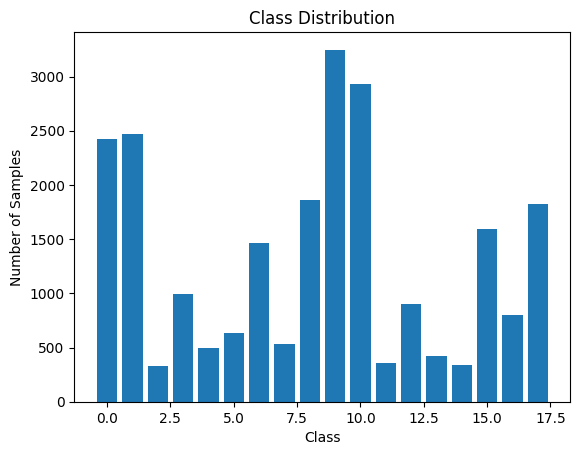

In [9]:
from collections import Counter
import matplotlib.pyplot as plt

class_counts = Counter(y)
print("Class Distribution:", class_counts)

plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.title("Class Distribution")
plt.show()

In [10]:
smote = SMOTE(random_state=42)
x_balanced, y_balanced = smote.fit_resample(x, y)

Class Distribution: Counter({0: 3248, 1: 3248, 2: 3248, 3: 3248, 4: 3248, 5: 3248, 6: 3248, 7: 3248, 8: 3248, 9: 3248, 10: 3248, 11: 3248, 12: 3248, 13: 3248, 14: 3248, 15: 3248, 16: 3248, 17: 3248})


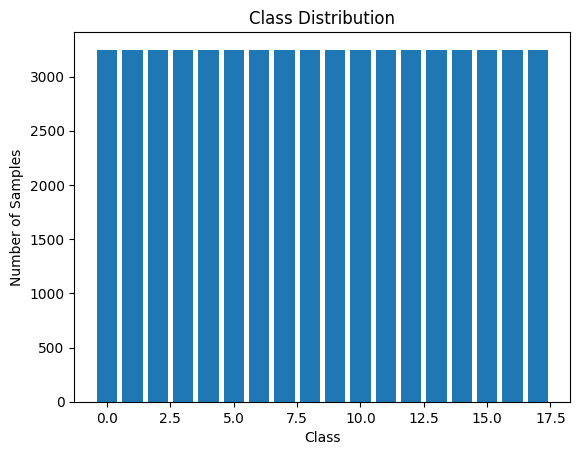

In [11]:
from collections import Counter
import matplotlib.pyplot as plt

class_counts = Counter(y_balanced)
print("Class Distribution:", class_counts)

plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.title("Class Distribution")
plt.show()

In [12]:
x_train, x_test, y_train, y_test = train_test_split(x_balanced, y_balanced, test_size=0.3, random_state=42)

standard_scaler = StandardScaler()
x_train = standard_scaler.fit_transform(x_train)
x_test = standard_scaler.transform(x_test)

rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(x_train, y_train)

y_train_pred = rf_model.predict(x_train)
print(f"Training Accuracy: {accuracy_score(y_train, y_train_pred)}")
print(classification_report(y_train, y_train_pred))

y_test_pred = rf_model.predict(x_test)
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred)}")
print(classification_report(y_test, y_test_pred))

Training Accuracy: 0.9695777538852507
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      2282
           1       0.98      0.99      0.99      2249
           2       1.00      1.00      1.00      2290
           3       1.00      1.00      1.00      2254
           4       0.97      0.95      0.96      2241
           5       0.94      0.94      0.94      2256
           6       0.97      0.99      0.98      2257
           7       0.87      0.96      0.91      2246
           8       1.00      1.00      1.00      2304
           9       0.92      0.98      0.95      2268
          10       0.99      0.98      0.99      2305
          11       1.00      1.00      1.00      2288
          12       1.00      1.00      1.00      2271
          13       0.94      0.94      0.94      2273
          14       0.93      0.98      0.95      2293
          15       0.99      0.94      0.97      2288
          16       0.97      0.83      0.90

In [13]:
from sklearn.svm import SVC

svm_model = SVC(kernel='rbf', C=1, gamma='scale', random_state=42)

svm_model.fit(x_train, y_train)

y_train_pred_svm = svm_model.predict(x_train)
print(f"Training Accuracy: {accuracy_score(y_train, y_train_pred_svm)}")
print(classification_report(y_train, y_train_pred_svm))

y_test_pred_svm = svm_model.predict(x_test)
print(f"Testing Accuracy: {accuracy_score(y_test, y_test_pred_svm)}")
print(classification_report(y_test, y_test_pred_svm))


Training Accuracy: 0.892068224025022
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2282
           1       0.98      1.00      0.99      2249
           2       1.00      1.00      1.00      2290
           3       1.00      1.00      1.00      2254
           4       0.65      0.76      0.70      2241
           5       0.71      0.57      0.64      2256
           6       0.98      1.00      0.99      2257
           7       0.68      0.94      0.79      2246
           8       1.00      0.99      0.99      2304
           9       0.97      0.96      0.97      2268
          10       0.99      0.98      0.98      2305
          11       1.00      1.00      1.00      2288
          12       1.00      1.00      1.00      2271
          13       0.65      0.66      0.65      2273
          14       0.66      0.63      0.65      2293
          15       0.99      0.96      0.98      2288
          16       0.89      0.63      0.74 

In [20]:
from sklearn.naive_bayes import GaussianNB

naive_model = GaussianNB()

naive_model.fit(x_train, y_train)

y_train_pred_naive = naive_model.predict(x_train)
print(f"Training Accuracy: {accuracy_score(y_train, y_train_pred_naive)}")
print(classification_report(y_train, y_train_pred_naive))

y_test_pred_naive = naive_model.predict(x_test)
print(f"Testing Accuracy: {accuracy_score(y_test, y_test_pred_naive)}")
print(classification_report(y_test, y_test_pred_naive))

Training Accuracy: 0.6423858860326459
              precision    recall  f1-score   support

           0       0.53      0.90      0.67      2282
           1       0.51      0.24      0.32      2249
           2       0.95      1.00      0.98      2290
           3       0.97      0.96      0.96      2254
           4       0.75      0.02      0.05      2241
           5       0.40      0.89      0.56      2256
           6       0.43      0.92      0.59      2257
           7       0.51      0.96      0.67      2246
           8       0.77      0.74      0.76      2304
           9       0.47      0.27      0.34      2268
          10       0.85      0.44      0.58      2305
          11       1.00      1.00      1.00      2288
          12       0.97      0.89      0.93      2271
          13       0.69      0.20      0.31      2273
          14       0.47      0.49      0.48      2293
          15       0.83      0.56      0.67      2288
          16       0.56      0.51      0.53